In [56]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
#from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
#from dask_ml.linear_model import LogisticRegression
#from dask_ml.linear_model import LinearRegression
#from sklearn.linear_model import Ridge

import h5py
import keras
from keras.layers.core import Dropout
from keras.models import load_model

import geopandas
from rasterio import features
from affine import Affine

import dask
#import dask.multiprocessing
dask.config.set(scheduler='threads')

import xarray as xr
from dask.diagnostics import ProgressBar

In [2]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/bin/python3


In [3]:
def sfloat(f):
    return str(float(f))
def sint(i):
    return str(int(i))

In [4]:
def read_glofas_danube():
    glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
    glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
    glofas = shift_time(glofas, -dt.timedelta(days=1))  # the discharge is the mean of the previous 24h of the timestamp
    return glofas

In [5]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [43]:
def select_riverpoints(dis):
    return (dis > 10)

In [7]:
def get_mask_of_basin(da, kw_basins='Danube'):
    """
    Parameters:
    -----------
        da : xr.DataArray
            contains the coordinates
        kw_basins : str
            identifier of the basin in the basins dataset
    """
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))
    
    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
#    print(basins)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
#    print(single_basin)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    da = da.basins == 0
    return da.drop('basins')
    

In [53]:
def select_upstream(is_river, lat, lon, basin='Danube'):
    
    
    # longitude condition
    is_west = (~np.isnan(is_river.where(is_river.longitude <= lon))).astype(bool)
    
    mask_basin = get_mask_of_basin(is_river, kw_basins=basin)

    nearby_mask = is_river*0.
    nearby_mask.loc[dict(latitude=slice(lat+1.5, lat-1.5), 
                         longitude=slice(lon-1.5, lon+1.5))] = 1.
    nearby_mask = nearby_mask.astype(bool)
    
    mask = mask_basin & nearby_mask & is_west #mask_box_mean_greater & 
    if 'basins' in mask.coords:
        mask = mask.drop('basins')
    if 'time' in mask.coords:
        mask = mask.drop('time')  # time and basins dimension make no sense here
    return mask

In [9]:
def train(pipe, X_train, y_train, X_valid, y_valid):
    history = pipe.fit(X_train.values, y_train.values,
                       model__validation_data=(X_valid.values, #.values, 
                                               y_valid.values)) #.values.reshape(-1,1)))

    h = history.named_steps['model'].model.history

    # Plot training & validation loss value
    plt.figure()
    plt.plot(h.history['loss'], label='loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend() #['Train', 'Test'], loc='upper left')
    plt.gca().set_yscale('log')
    plt.show()

In [10]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [11]:
def preprocess_reshape_flowmodel(X_dis, y_dis):
    """Reshape, merge predictor/predictand in time, drop nans."""
    X_dis = X_dis.to_array(dim='time_feature')  
    #print('X before feature-stacking', X_dis)
    X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
    #print('X before featuredrop', X_dis)
    Xar = X_dis.dropna('features', how='all')
    
    yar = y_dis
    yar = yar.drop(['latitude', 'longitude'])
    yar.coords['features'] = 'dis'
    
    #print('X, y before concat for time nan dropping', Xar, yar)
    Xy = xr.concat([Xar, yar], dim='features')
    Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
    time = Xyt.time
    
    Xda = Xyt[:,:-1]
    yda = Xyt[:,-1]
    return Xda, yda, time

In [ ]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

class FlowModel(object):
    def __init__(self, **kwargs):
        model = keras.models.Sequential()
        self.cfg = kwargs
        
        model.add(keras.layers.BatchNormalization())
        
        #model.add(Dropout(0.25))
        model.add(keras.layers.Dense(8,
                                  kernel_initializer=keras.initializers.Zeros(), 
                                  kernel_regularizer=keras.regularizers.l2(1e-4),
                                  bias_initializer='zeros',
                                  activation='relu'))

        model.add(keras.layers.Dense(1, activation='linear'))
        
        #opti = keras.optimizers.RMSprop(lr=.05)
        opti = keras.optimizers.Adadelta(lr=0.05, rho=0.95, epsilon=None, decay=0.0)
        #opti = keras.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.8, nesterov=True)

        model.compile(loss='mean_squared_error', 
                      optimizer=opti)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1, patience=10, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),
                         keras.callbacks.ModelCheckpoint(self.cfg.get('filepath'), 
                            monitor='val_loss', verbose=0, save_best_only=True, 
                            save_weights_only=False, mode='auto', period=1),]

    def predict(self, Xda, name=None):
        a = self.model.predict(Xda.values).squeeze()
        return add_time(a, Xda.time, name=name)

    def fit(self, Xda, yda, **kwargs):
        return self.model.fit(Xda, yda.reshape(-1,1),
                              epochs=self.cfg.get('epochs', None),
                              batch_size=512,
                              callbacks=self.callbacks,
                              verbose=0,
                              **kwargs)

In [ ]:
def create_FlowModel(filepath, initialdischarge):
    mlp_kws = dict(epochs=1000,
                   filepath = filepath,
                  )
    
    return Pipeline([#('scaler', StandardScaler()),
                     #('pca', PCA(n_components=2)),
                     ('model', FlowModel(**mlp_kws)),],
                     verbose=False)

In [14]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')

In [15]:
#era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')
#era5 = shift_time(era5, -dt.timedelta(hours=23))

era5 = xr.open_dataset('../data/danube/era5_danube_pressure_and_single_levels.nc')

In [16]:
glofas = read_glofas_danube()

In [17]:
glofas = glofas.isel(time=slice(0, 365*15))  # just to reduce the amount of data

In [18]:
if 'tp' in era5:
    tp = era5['tp']*1000
else:
    tp = (era5['cp']+era5['lsp'])*1000
tp.name = 'total precip [mm]'
tp = tp.interp(latitude=glofas.latitude,
               longitude=glofas.longitude)

## prepare training data for the FlowModel
### features = discharge upstream (t-1, ... t-3)
### target = discharge (t)


In [19]:
shifts = range(1,4)
X = add_shifted_predictors(glofas, shifts, variables='all')
X = X.drop('dis')  # current dis is to be predicted, is not a feature

y = glofas['dis']  # just this variable as dataarray

### for rgp in riverpoints:

In [35]:
N_train = dict(time=slice(None, '1990'))
N_valid = dict(time=slice('1990', '1995'))

fm_path = '../models/flowmodel/danube/flowmodel_lat_lon.h5'
if not os.path.isdir(os.path.dirname(modpath)):
    os.makedirs(os.path.dirname(modpath))

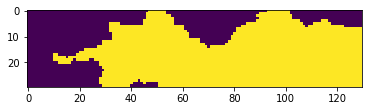

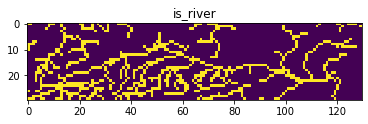

3
48.25 8.050000000000011 is spring.
3
48.15 8.050000000000011 is spring.
3
48.05 8.050000000000011 is spring.
6
6
6
9
9
9
12
12
12
15
15
15
17
17
47.95 8.550000000000011 is danube river -> train flowmodel


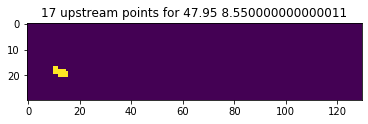

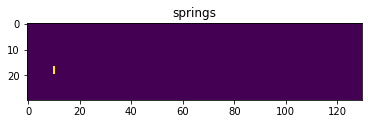

(1220, 51) (1220,)
(815, 51) (815,)
(502, 51) (502,)


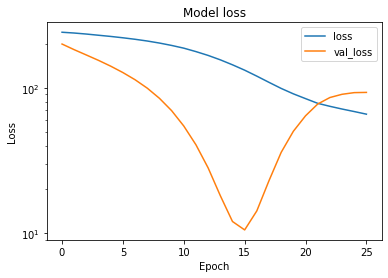

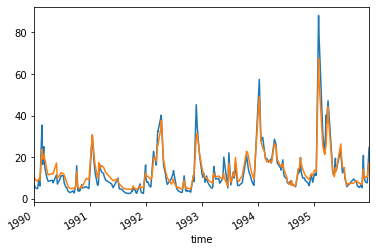

20
48.15 8.650000000000034 is danube river -> train flowmodel


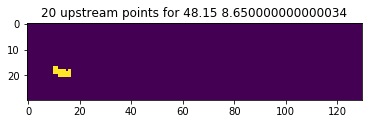

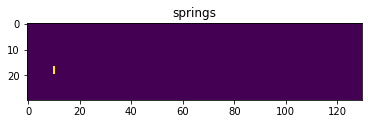

(1207, 60) (1207,)
(812, 60) (812,)
(492, 60) (492,)


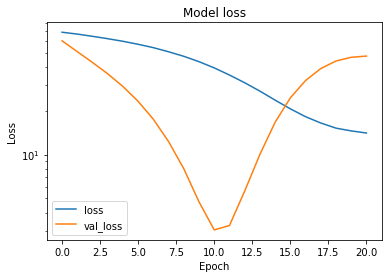

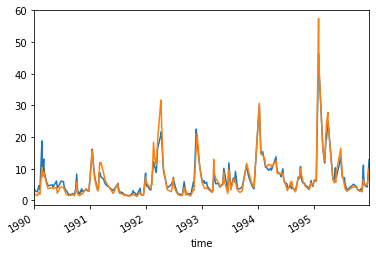

20
48.05 8.650000000000034 is danube river -> train flowmodel


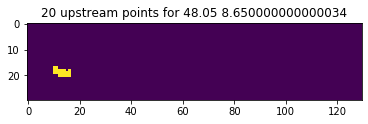

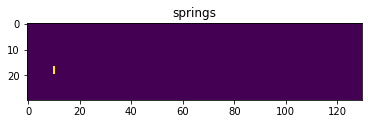

(1215, 60) (1215,)
(815, 60) (815,)
(497, 60) (497,)


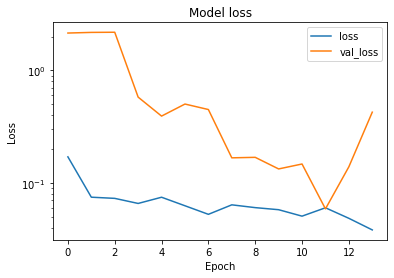

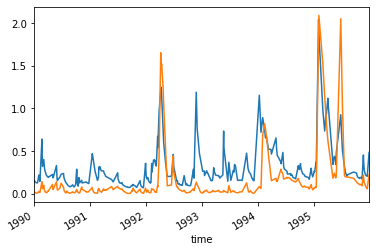

20
47.95 8.650000000000034 is danube river -> train flowmodel


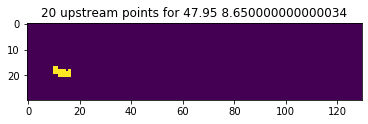

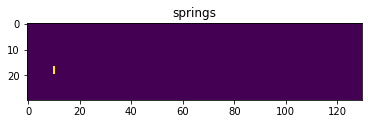

(1228, 60) (1228,)
(818, 60) (818,)
(506, 60) (506,)


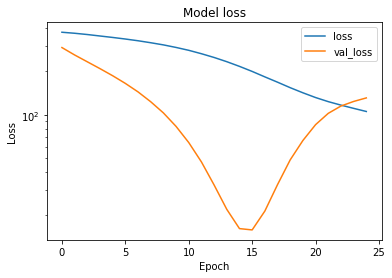

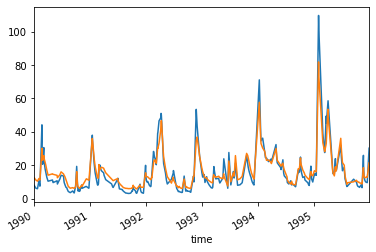

22
48.15 8.750000000000028 is danube river -> train flowmodel


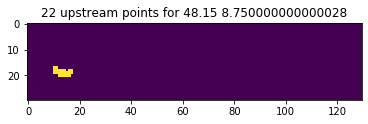

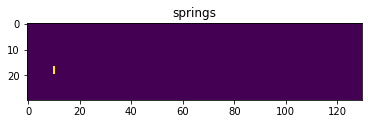

KeyboardInterrupt: 

In [71]:
#riverpoints = select_riverpoints(glofas)
danube_gridpoints = get_mask_of_basin(glofas['dis'].isel(time=0), 'Danube')

plt.imshow(danube_gridpoints.astype(int))
plt.show()

mask_springs = glofas['dis'].isel(time=0)
mask_springs.values[:] = 0.

dis_map_mean = glofas['dis'].mean('time')
is_river = select_riverpoints(dis_map_mean)
#river_min_discharge = 20
# mask_box_mean_greater = dis_box_mean > river_min_discharge
#mask_box_mean_greater = (~np.isnan(dis_map_mean.where(dis_map_mean > river_min_discharge))).astype(bool)
plt.imshow(is_river.astype(int))
plt.title('is_river')
plt.show()

for lon in danube_gridpoints.longitude:
    for lat in danube_gridpoints.latitude:
        #print(danube_gridpoints.sel(latitude=lat, longitude=lon))
        if danube_gridpoints.sel(latitude=lat, longitude=lon) == 1:
            lat, lon = float(lat), float(lon)
            
            lats, lons = sfloat(lat), sfloat(lon)
            
            modpath = fm_path.replace('lat', lats).replace('lon', lons)

            upstream = select_upstream(is_river, lat, lon, basin='Danube')

            N_upstream = int(upstream.sum())
            print(N_upstream)
            if N_upstream < 5:
                print(lats, lons, 'is spring.')
                mask_springs.loc[dict(latitude=lat, longitude=lon)] = 1.

                #plt.imshow(mask_springs.astype(int))
                #plt.title('springs')
                #plt.show()
            else:
                if not os.path.isfile(modpath):
                    print(lats, lons, 'is danube river -> train flowmodel')
                    plt.imshow(upstream.astype(int))
                    plt.title(str(N_upstream)+' upstream points for '+lats+' '+lons)
                    plt.show()
                    
                    plt.imshow(mask_springs.astype(int))
                    plt.title('springs')
                    plt.show()
                    
                    
                    tp_box = tp.loc[dict(latitude=slice(lat+1.5, lat-1.5), 
                                         longitude=slice(lon-1.5, lon+1.5))] 
                    noprecip = tp_box.mean(['longitude', 'latitude']) < 0.1

                    Xt = X.where(noprecip, drop=True)
                    Xt = Xt.where(upstream, drop=True)
                    yt = y.sel(latitude=float(lat), longitude=float(lon))

                    #print(Xt, upstream)
                    Xda, yda, time = preprocess_reshape_flowmodel(Xt, yt)
                    print(Xda.shape, yda.shape)
                    
                    #X_train = Xda[:N_train,:] 
                    #y_train = yda[:N_train] 
                    #X_valid = Xda[N_train:N_train+N_valid,:] 
                    #y_valid = yda[N_train:N_train+N_valid] 
                    
                    X_train = Xda.loc[N_train] 
                    y_train = yda.loc[N_train] 
                    X_valid = Xda.loc[N_valid] 
                    y_valid = yda.loc[N_valid] 
                    
                    print(X_train.shape, y_train.shape)
                    print(X_valid.shape, y_valid.shape)
                    initialdischarge = np.mean(y_train)
                    pipe = create_FlowModel(modpath, initialdischarge)

                    train(pipe, X_train, y_train, X_valid, y_valid)
                    
                    
                    model = load_model(modpath)
                    y_m = model.predict(X_valid) #, y_valid.time)
                    y_m = add_time(y_m.squeeze(), y_valid.time, name='flowmodel')
                    y_m.to_pandas().plot()
                    y_valid.name = 'reanalysis'
                    y_valid.to_pandas().plot()
                    plt.show()
                    
                    

In [34]:
@dask.delayed
def train_flowmodel(lat, lon):    
    lats, lons = sfloat(lat), sfloat(lon)

    modpath = fm_path.replace('lat', lats).replace('lon', lons)

    upstream = select_upstream(is_river, lat, lon, basin='Danube')
    N_upstream = int(upstream.sum())
    
    if N_upstream < 5:
        mask_springs.loc[dict(latitude=lat, longitude=lon)] = 1.
    else:
        if not os.path.isfile(modpath):
            print(lats, lons, 'is danube river -> train flowmodel')

            tp_box = tp.loc[dict(latitude=slice(lat+1.5, lat-1.5), 
                                 longitude=slice(lon-1.5, lon+1.5))] 
            noprecip = tp_box.mean(['longitude', 'latitude']) < 0.1

            Xt = X.where(noprecip, drop=True)
            Xt = Xt.where(upstream, drop=True)
            yt = y.sel(latitude=float(lat), longitude=float(lon))

            #print(Xt, upstream)
            Xda, yda, time = preprocess_reshape_flowmodel(Xt, yt)
            print(Xda.shape, yda.shape)

            X_train = Xda.loc[N_train] 
            y_train = yda.loc[N_train] 
            X_valid = Xda.loc[N_valid] 
            y_valid = yda.loc[N_valid] 

            initialdischarge = np.mean(y_train)
            pipe = create_FlowModel(modpath, initialdischarge)

            train(pipe, X_train, y_train, X_valid, y_valid)

In [ ]:
#riverpoints = select_riverpoints(glofas)
danube_gridpoints = get_mask_of_basin(glofas['dis'].isel(time=0), 'Danube')

plt.imshow(danube_gridpoints.astype(int))
plt.show()

mask_springs = glofas['dis'].isel(time=0)
mask_springs.values[:] = 0.

task_list = []

for lon in danube_gridpoints.longitude:
    for lat in danube_gridpoints.latitude:
        #print(danube_gridpoints.sel(latitude=lat, longitude=lon))
        if danube_gridpoints.sel(latitude=lat, longitude=lon) == 1:
            task_list.append(train_flowmodel(lat, lon))           

In [ ]:
len(task_list)

In [ ]:
with ProgressBar():
    dask.compute(task_list)

In [ ]:
X_valid.values.shape

In [ ]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = X_train.min('features')
maxpred = X_train.max('features')

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')


dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_train_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(dt.datetime(1981,1,1), y_train_pred.time.values[-1]) 

In [ ]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = add_time(Xda.min(axis=1), time)
maxpred = add_time(Xda.max(axis=1), time)

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')

dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_valid_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(y_valid_pred.time.values[0], y_valid_pred.time.values[-1]) 

## Verification

Is the NN model better than using the max value of all predictors?

In [ ]:
def to_5yr(dis):
    return dis/glofas_rl['rl5'].sel(latitude=dis.latitude, longitude=dis.longitude)

In [ ]:
((y_train_pred-y_train)/y_train*100).plot(label=)
X_train.max('features').plot(label='max_feature')